# TSLA vs F During COVID-19: Volatility and Risk-Adjusted Performance (2020–2022)

**Course:** Financial Data Analytics I  
**Team Members:** Jonatan Alcala, Aaron Garcia, Alejandro Rivera  

---

## Project Overview

This notebook analyzes how **Tesla (TSLA)** and **Ford (F)** behaved during the COVID-19 pandemic, focusing on:

- Volatility and risk-adjusted returns  
- Short-term price reactions to **specific COVID-related market shocks**  

We deliberately combine:

1. **Full-period analysis (2020–2022)** – broad view of performance and risk.
2. **Narrow event windows** around key COVID-19 events – to respond to the professor’s feedback
   about attribution (avoiding “too noisy” long windows).

We also benchmark against:

- **S&P 500 Index** (as the broad market, symbol: `^GSPC`)
- **Macroeconomic indicators** (from FRED), such as:
  - CPI (inflation) – `CPIAUCSL`
  - 3-Month T-Bill (proxy for risk-free rate) – `TB3MS`  

All analysis is done in **Python** using `pandas`, `numpy`, `yfinance`, `matplotlib`, and `seaborn`.

---

## Research Questions

1. **Volatility and Risk-Adjusted Return Analysis**  
   - How did **Tesla (TSLA)** and **Ford (F)** differ in stock volatility and risk-adjusted returns during 2020–2022?  
   - Which stock delivered higher *risk-adjusted* performance (Sharpe ratio)?

2. **Event-Driven Volatility Comparison (Market Shock Analysis)**  
   - How did major COVID-19 events affect **short-term price movements** of TSLA and F?  
   - Did Tesla and Ford react differently around:
     - WHO’s pandemic declaration (March 11, 2020)
     - The CARES Act stimulus (March 27, 2020)
     - Pfizer/BioNTech vaccine efficacy announcement (November 9, 2020)?

---

## Notebook Structure

1. **Data acquisition** (TSLA, F, S&P 500, FRED macro series)
2. **Cleaning & feature engineering** (returns, rolling volatility, Sharpe inputs)
3. **Descriptive statistics** (means, std devs, correlations)
4. **Visualizations**
   - Normalized price paths vs S&P 500
   - 30-day rolling volatility
   - Sharpe ratio bar chart
5. **Event-study analysis** with narrow event windows

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Data sources
import yfinance as yf

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Dates
from datetime import datetime, timedelta

# Stats
from scipy import stats

# import FRED API for macro data
try:
    from fredapi import Fred
    FRED_AVAILABLE = True
except ImportError:
    FRED_AVAILABLE = False

# Plotting aesthetics
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

# Display options
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
pd.set_option("display.max_columns", 50)


---

## Parameters and Event Window Design

To respond to the professor’s feedback, we **do not rely only on the entire 2020–2022 period** to attribute
changes to COVID. Instead, we define **narrow windows** around specific shocks:

- **WHO declares COVID-19 a pandemic** – March 11, 2020  
- **CARES Act stimulus signed into law** – March 27, 2020  
- **Pfizer/BioNTech vaccine efficacy announcement** – November 9, 2020  

For each event, we will analyze a **short window** (e.g., 10 trading days before and after the event) to
see how TSLA and F behaved relative to each other and to the market.

We also define:

- Overall sample: **2020-01-01 to 2022-12-31**
- Risk-free rate: proxied by **3-Month T-Bill (TB3MS)** from FRED, annualized and converted to daily.

*WHO (World Health Organization) pandemic declaration: March 11, 2020; CARES Act signed March 27, 2020; Pfizer/BioNTech vaccine efficacy news November 9, 2020.*

In [2]:
#  Core parameters

start_date = "2020-01-01"
end_date   = "2022-12-31"

stock_tickers = ["TSLA", "F"]           # Tesla & Ford
benchmark_ticker = "^GSPC"              # S&P 500

# Event windows: short windows around key COVID-related shocks
event_window_days = 10   # e.g., 10 trading days before and after each event

event_dates = {
    "WHO_pandemic_announcement": "2020-03-11",
    "CARES_Act_signed": "2020-03-27",
    "Pfizer_vaccine_news": "2020-11-09"
}

# FRED configuration 
FRED_API_KEY = "ac08aafee7abbbe826ceef2803cd4ae6"  

# FRED series IDs
FRED_SERIES = {
    "CPI": "CPIAUCSL",   # CPI, all urban consumers, all items
    "TBILL_3M": "TB3MS"  # 3-month T-bill, proxy for risk-free rate
}


---

## 1. Data Acquisition Plan

We gather three types of data:

1. **Equity prices (daily)**  
   - TSLA  
   - F  
   - S&P 500 (`^GSPC`)

2. **Macroeconomic data (FRED)** – via `fredapi`
   - CPI (`CPIAUCSL`) – monthly  
   - 3-Month T-Bill (`TB3MS`) – monthly, used as a **proxy for risk-free rate**

3. **Event dates** – hard-coded in this notebook, based on historical COVID-19 milestones.

Daily equity prices are downloaded via **Yahoo Finance** (`yfinance.download`), with **Adjusted Close** prices used for returns.

### Download Equity Data (TSLA, F, S&P 500)

In [3]:
#  Download stock and benchmark data

all_tickers = stock_tickers + [benchmark_ticker]

# Using yfinance to download daily OHLCV data
raw_data = yf.download(
    tickers=all_tickers,
    start=start_date,
    end=end_date,
    progress=False,
    auto_adjust=False  # we'll explicitly use 'Adj Close'
)

# Extract Adjusted Close prices and rename columns
prices = raw_data["Adj Close"].copy()
prices = prices.rename(columns={benchmark_ticker: "SP500"})

# Sort by date (index)
prices = prices.sort_index()

print("Head of Adjusted Close price data:")
display(prices.head())


Head of Adjusted Close price data:


Ticker,F,TSLA,SP500
Date,,,
2020-01-02,7.0279,28.6840,"3,257.8501"
2020-01-03,6.8712,29.5340,"3,234.8501"
2020-01-06,6.8339,30.1027,"3,246.2800"
2020-01-07,6.9011,31.2707,"3,237.1799"
2020-01-08,6.9011,32.8093,"3,253.0500"


### Download Macro Data (FRED)

In [4]:
if FRED_AVAILABLE and FRED_API_KEY not in (None, ""):
    fred = Fred(api_key=FRED_API_KEY)

    # CPI (monthly)
    cpi = fred.get_series(
        FRED_SERIES["CPI"],
        observation_start=start_date,
        observation_end=end_date
    )
    cpi = cpi.to_frame(name="CPI")
    cpi.index = pd.to_datetime(cpi.index)

    # 3-month T-bill (monthly)
    tbill = fred.get_series(
        FRED_SERIES["TBILL_3M"],
        observation_start=start_date,
        observation_end=end_date
    )
    tbill = tbill.to_frame(name="TBILL_3M")
    tbill.index = pd.to_datetime(tbill.index)

    macro_daily = (
        pd.concat([cpi, tbill], axis=1)
        .resample("B")
        .ffill()
        .loc[prices.index.min(): prices.index.max()]
    )

    print("Head of macro data (daily, forward-filled from monthly):")
    display(macro_daily.head())

else:
    macro_daily = None
    print("FRED not available or API key not set.")


Head of macro data (daily, forward-filled from monthly):


,CPI,TBILL_3M
2020-01-02,259.1270,1.5200
2020-01-03,259.1270,1.5200
2020-01-06,259.1270,1.5200
2020-01-07,259.1270,1.5200
2020-01-08,259.1270,1.5200


---

## 2. Cleaning & Feature Engineering

For each stock (TSLA, F) and the S&P 500:

### **2a. Daily returns**
$$
r_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

### **2b. Rolling 30-day volatility**
$$
\sigma_{t,30} = \text{StdDev}(r_{t-29}, \dots, r_t)
$$

### **2c. Risk-free rate (daily)**
If 3-month T-bill yield is annualized, the daily risk-free rate is approximated by:
$$
r_f^{\text{daily}} \approx \frac{r_f^{\text{annual}}}{252}
$$

If not available:
$$
r_f^{\text{daily}} = 0
$$

### **2d. Annualized Sharpe ratio**
For daily returns \(r_t\) and daily risk-free rate \(r_{f,t}\):
$$
\text{Sharpe} =
\frac{\sqrt{252}\,\mathbb{E}[r_t - r_{f,t}]}
{\text{StdDev}(r_t - r_{f,t})}
$$

In [5]:
#  Compute daily returns & volatility

# Daily returns for each series (aligned to prices index)
returns = prices.pct_change().dropna()

# Rename columns for clarity
returns = returns.rename(
    columns={
        "TSLA": "TSLA_ret",
        "F": "F_ret",
        "SP500": "SP500_ret"
    }
)

# 30-day rolling volatility of daily returns
rolling_vol = returns.rolling(window=30).std()  # 30 trading days ~ 1.5 months

#  Construct daily risk-free rate series

if macro_daily is not None and "TBILL_3M" in macro_daily.columns:
    # Convert TBILL_3M from percent per annum to decimal per year
    annual_rf = macro_daily["TBILL_3M"] / 100.0

    # Approximate daily risk-free rate as annual_rf / 252
    daily_rf = (annual_rf / 252.0).reindex(returns.index, method="ffill")

else:
    # Fallback: assume zero risk-free rate (document in write-up)
    daily_rf = pd.Series(0.0, index=returns.index, name="rf_daily")
    print(
        "Warning: No T-bill data. Using 0% as risk-free rate for Sharpe ratio "
        "(Sharpe ≈ mean/std)."
    )

daily_rf.name = "rf_daily"

# Combine into a single DataFrame
data = pd.concat([prices, returns, rolling_vol.add_suffix("_vol"), daily_rf], axis=1)

print("Combined data (head):")
display(data.head())


Combined data (head):


,F,TSLA,SP500,F_ret,TSLA_ret,SP500_ret,F_ret_vol,TSLA_ret_vol,SP500_ret_vol,rf_daily
Date,,,,,,,,,,
2020-01-02,7.0279,28.6840,"3,257.8501",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,6.8712,29.5340,"3,234.8501",-0.0223,0.0296,-0.0071,NaN,NaN,NaN,0.0001
2020-01-06,6.8339,30.1027,"3,246.2800",-0.0054,0.0193,0.0035,NaN,NaN,NaN,0.0001
2020-01-07,6.9011,31.2707,"3,237.1799",0.0098,0.0388,-0.0028,NaN,NaN,NaN,0.0001
2020-01-08,6.9011,32.8093,"3,253.0500",0.0000,0.0492,0.0049,NaN,NaN,NaN,0.0001


### Helper Functions

In [6]:
def annualized_sharpe(daily_returns: pd.Series, daily_rf: pd.Series, trading_days=252):
    """
    Compute annualized Sharpe ratio for a series of daily returns.
    daily_returns: pd.Series of daily returns for a given asset.
    daily_rf: pd.Series of daily risk-free rates aligned by index.
    """
    aligned_rf = daily_rf.reindex(daily_returns.index, method="ffill")
    excess = daily_returns - aligned_rf

    mu = excess.mean()
    sigma = excess.std()

    if sigma == 0:
        return np.nan

    sharpe = np.sqrt(trading_days) * mu / sigma
    return sharpe


def get_event_window(df: pd.DataFrame, event_date: str, window: int):
    """
    Extract a window of data around a specific event date.

    Parameters:
        df: DataFrame indexed by date.
        event_date: string 'YYYY-MM-DD'.
        window: number of trading days before and after the event.

    Returns:
        sub_df: DataFrame sliced to [event_date - window, event_date + window].
        day_offset: integer series where 0 = event day, negative = before, positive = after.
    """
    event_dt = pd.to_datetime(event_date)
    # Ensure event is in the index; if not, find the next trading day
    if event_dt not in df.index:
        event_dt = df.index[df.index.get_loc(event_dt, method="nearest")]

    start_dt = df.index[df.index.get_loc(event_dt) - window] if df.index.get_loc(event_dt) - window >= 0 else df.index[0]
    end_pos = df.index.get_loc(event_dt) + window
    end_dt = df.index[end_pos] if end_pos < len(df.index) else df.index[-1]

    sub_df = df.loc[start_dt:end_dt].copy()
    # Day offset relative to the event date
    sub_df["day_offset"] = (sub_df.index - event_dt).days

    return sub_df, event_dt


---

## 3. Descriptive Statistics (2020–2022)

Here we summarize, for TSLA, F, and the S&P 500:

- Mean daily return  
- Standard deviation of daily returns  
- Annualized Sharpe ratio (based on our risk-free proxy)  
- Correlation with the S&P 500  

In [7]:
#  Descriptive statistics

assets = ["TSLA_ret", "F_ret", "SP500_ret"]

stats_summary = []

for col in assets:
    sr = annualized_sharpe(returns[col], daily_rf)
    stats_summary.append(
        {
            "Asset": col.replace("_ret", ""),
            "Mean Daily Return": returns[col].mean(),
            "Std Dev Daily Return": returns[col].std(),
            "Annualized Sharpe": sr
        }
    )

stats_df = pd.DataFrame(stats_summary)
print("Descriptive statistics (2020–2022):")
display(stats_df)

# Correlation matrix of daily returns
corr_matrix = returns[assets].corr()
print("Correlation matrix of daily returns:")
display(corr_matrix)


Descriptive statistics (2020–2022):


,Asset,Mean Daily Return,Std Dev Daily Return,Annualized Sharpe
0,TSLA,0.0030,0.0455,1.0236
1,F,0.0008,0.0312,0.4074
2,SP500,0.0003,0.0160,0.3115


Correlation matrix of daily returns:


Ticker,TSLA_ret,F_ret,SP500_ret
Ticker,,,
TSLA_ret,1.0000,0.3686,0.5127
F_ret,0.3686,1.0000,0.6239
SP500_ret,0.5127,0.6239,1.0000


---

## 4. Visualizations

### **Normallized price paths vs S&P 500**

To compare TSLA, F, and the S&P 500 on a common scale, we normalize prices to 1.0 on the first
trading day of the sample (2020-01-02).

This allows us to visually inspect:

- Which stock outperformed the market over 2020–2022  
- Differences in drawdowns and recoveries during COVID-related episodes 

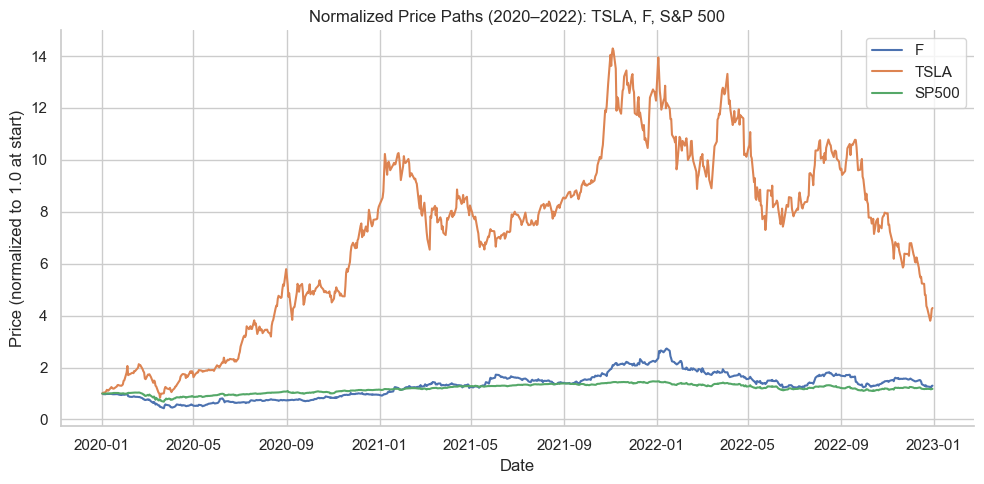

In [8]:
#  Normalized price paths
norm_prices = prices / prices.iloc[0]

plt.figure()
for col in norm_prices.columns:
    plt.plot(norm_prices.index, norm_prices[col], label=col)

plt.title("Normalized Price Paths (2020–2022): TSLA, F, S&P 500")
plt.xlabel("Date")
plt.ylabel("Price (normalized to 1.0 at start)")
plt.legend()
plt.tight_layout()
plt.show()

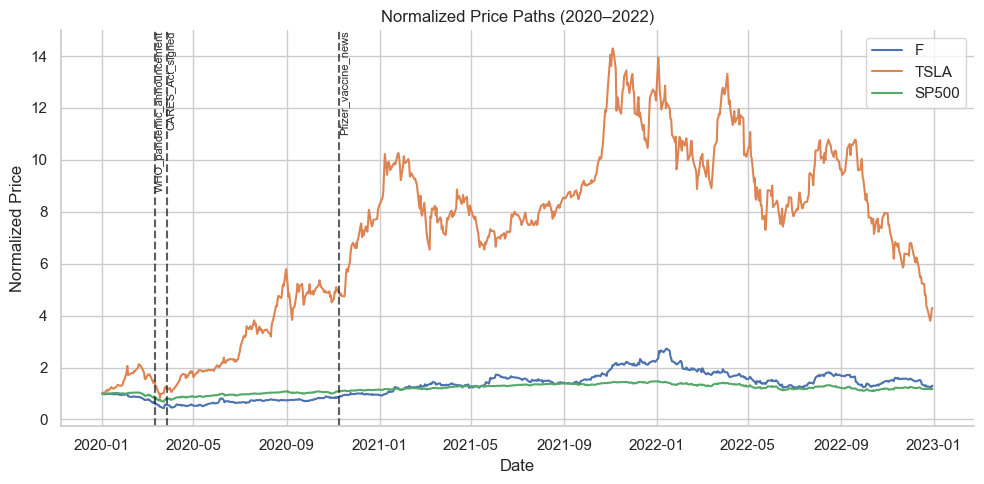

In [9]:
plt.figure()

for col in norm_prices.columns:
    plt.plot(norm_prices.index, norm_prices[col], label=col)

# Add vertical announcement lines
for name, date_str in event_dates.items():
    date = pd.to_datetime(date_str)
    plt.axvline(x=date, color='k', linestyle='--', alpha=0.7)
    plt.text(date, plt.ylim()[1], name,
             rotation=90, verticalalignment='top', fontsize=8)

plt.title("Normalized Price Paths (2020–2022)")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.tight_layout()
plt.show()


### **30-day rolling volatility**

We compute and plot **30-day rolling standard deviation of daily returns** for TSLA and F:

- Higher volatility → larger short-term price swings  
- Comparing TSLA vs F shows which stock was “riskier” at different times  

Optionally, if macro data (e.g., CPI or Fed Fund proxy) are available, we can visually relate
volatility spikes to macro dynamics (but the main focus is **stock-to-stock comparison**).

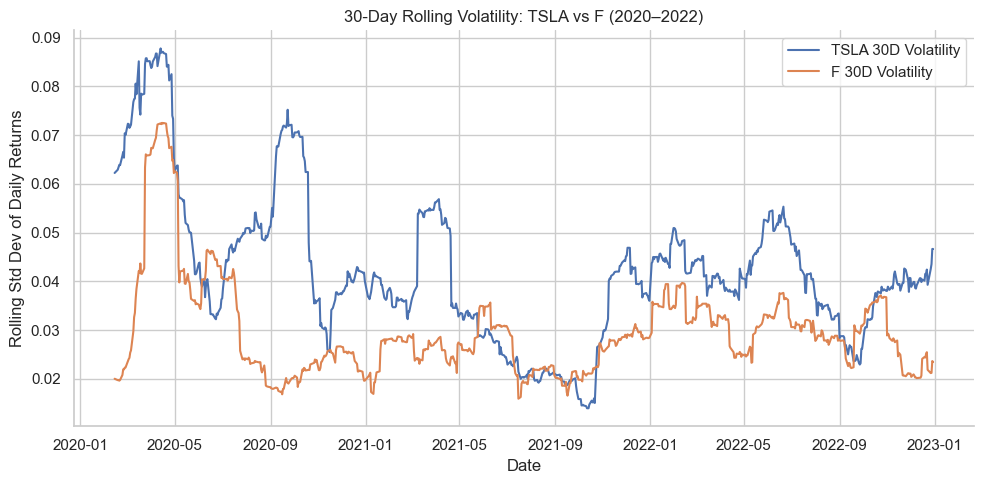

In [10]:
plt.figure()
plt.plot(rolling_vol.index, rolling_vol["TSLA_ret"], label="TSLA 30D Volatility")
plt.plot(rolling_vol.index, rolling_vol["F_ret"], label="F 30D Volatility")

plt.title("30-Day Rolling Volatility: TSLA vs F (2020–2022)")
plt.xlabel("Date")
plt.ylabel("Rolling Std Dev of Daily Returns")
plt.legend()
plt.tight_layout()
plt.show()

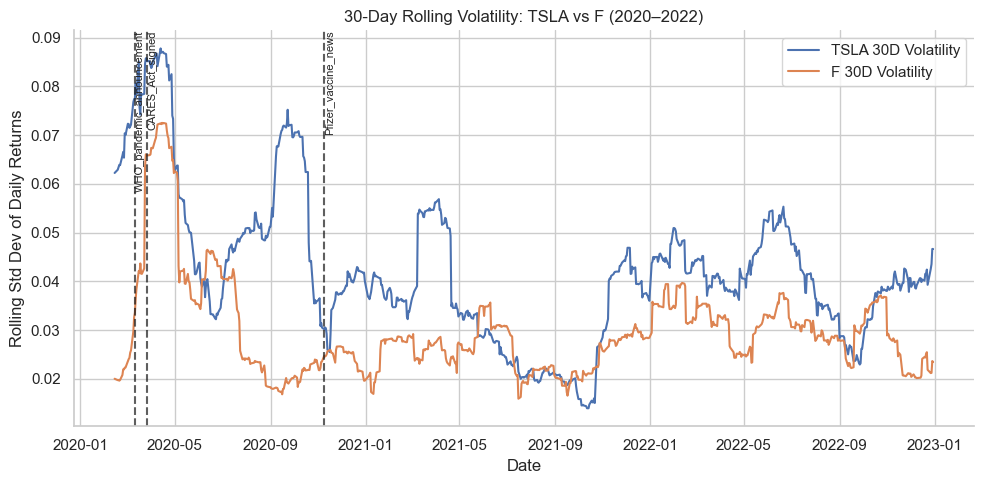

In [11]:
plt.figure()
plt.plot(rolling_vol.index, rolling_vol["TSLA_ret"], label="TSLA 30D Volatility")
plt.plot(rolling_vol.index, rolling_vol["F_ret"], label="F 30D Volatility")

for name, date_str in event_dates.items():
    date = pd.to_datetime(date_str)
    plt.axvline(x=date, color='k', linestyle='--', alpha=0.7)
    plt.text(date, plt.ylim()[1], name,
             rotation=90, verticalalignment='top', fontsize=8)

plt.title("30-Day Rolling Volatility: TSLA vs F (2020–2022)")
plt.xlabel("Date")
plt.ylabel("Rolling Std Dev of Daily Returns")
plt.legend()
plt.tight_layout()
plt.show()

### **Risk-Adjusted Returns (Sharpe Ratios)**

We now summarize the **risk-adjusted performance** of TSLA and F using the **annualized Sharpe ratio**:

- A higher Sharpe ratio means more return per unit of risk.
- We use the 3-month T-Bill rate as the risk-free proxy when available, otherwise 0%.

The bar chart gives a simple, presentation-friendly comparison.

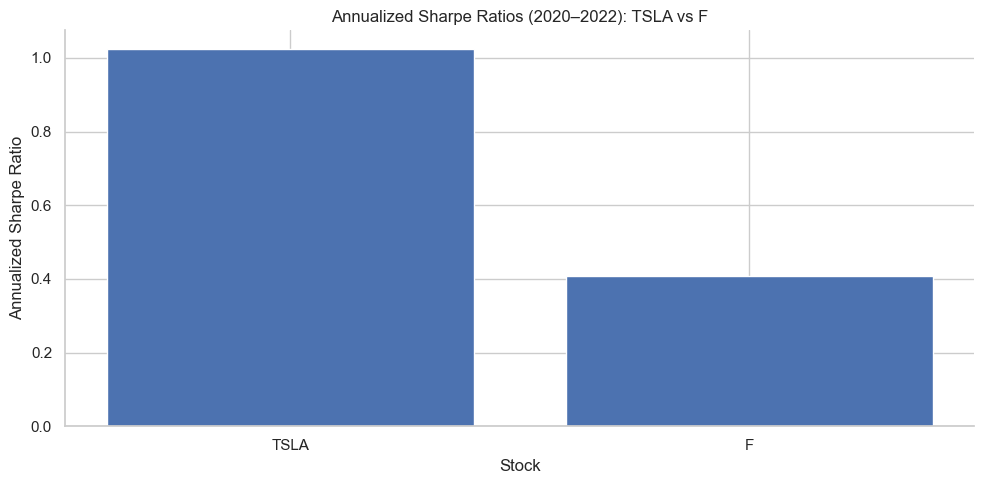

Sharpe ratios used in the chart:


,Asset,Mean Daily Return,Std Dev Daily Return,Annualized Sharpe
0,TSLA,0.0030,0.0455,1.0236
1,F,0.0008,0.0312,0.4074


In [12]:
#  Bar chart of Sharpe ratios for TSLA and F

sharpe_plot_df = stats_df[stats_df["Asset"].isin(["TSLA", "F"])].copy()

plt.figure()
plt.bar(sharpe_plot_df["Asset"], sharpe_plot_df["Annualized Sharpe"])
plt.title("Annualized Sharpe Ratios (2020–2022): TSLA vs F")
plt.ylabel("Annualized Sharpe Ratio")
plt.xlabel("Stock")
plt.tight_layout()
plt.show()

print("Sharpe ratios used in the chart:")
display(sharpe_plot_df)


---

## 5. Even-Study Analysis

Short-Term Reactions to COVID-Related Shocks

To address the concern that a 2-year window is **too noisy** for causal interpretation, we run
**event-study style analyses** around specific COVID-related events:

1. **WHO pandemic announcement** – 2020-03-11  
2. **CARES Act signed into law** – 2020-03-27  
3. **Pfizer/BioNTech vaccine efficacy news** – 2020-11-09  

For each event:

- We take a window of **±10 trading days** around the event.
- We compute:
  - Cumulative returns for TSLA and F within the window
  - Average volatility before vs after the event
  - Simple visual comparison of normalized prices around the event date

This lets us answer:  
> Did TSLA and F react differently in the **short run** to identical macro shocks?

### **Event-Study Plots per Event**

Event: WHO_pandemic_announcement (2020-03-11)


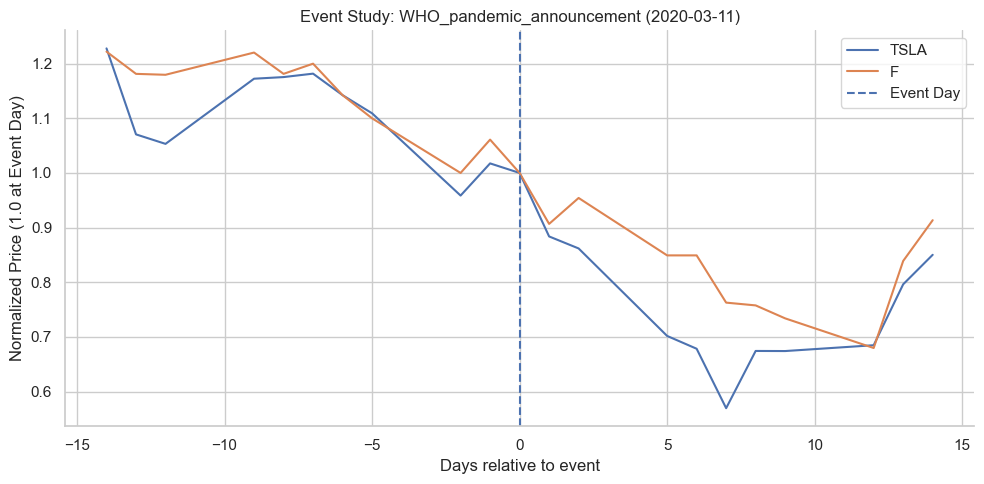

Cumulative return from event day to end of window for WHO_pandemic_announcement:


,Cumulative_Return
Ticker,
TSLA,-0.1498
F,-0.0864


Event: CARES_Act_signed (2020-03-27)


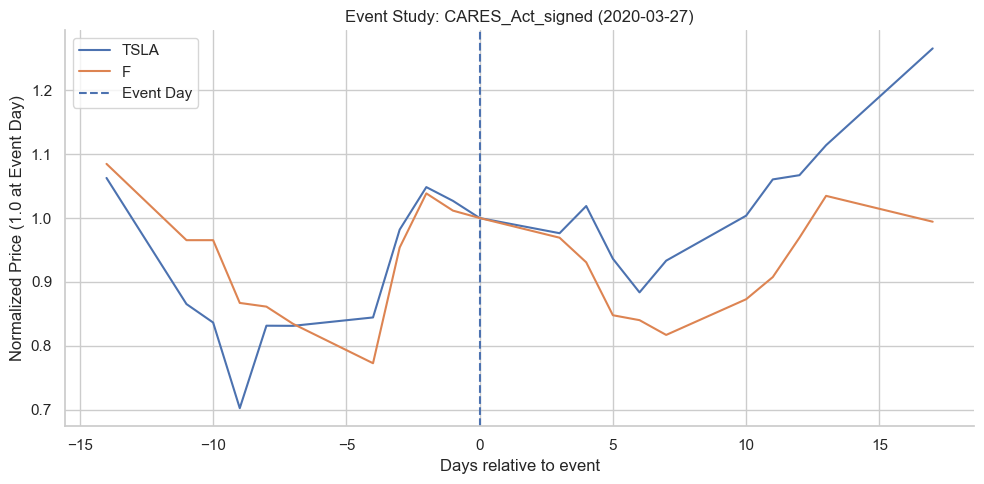

Cumulative return from event day to end of window for CARES_Act_signed:


,Cumulative_Return
Ticker,
TSLA,0.2656
F,-0.0058


Event: Pfizer_vaccine_news (2020-11-09)


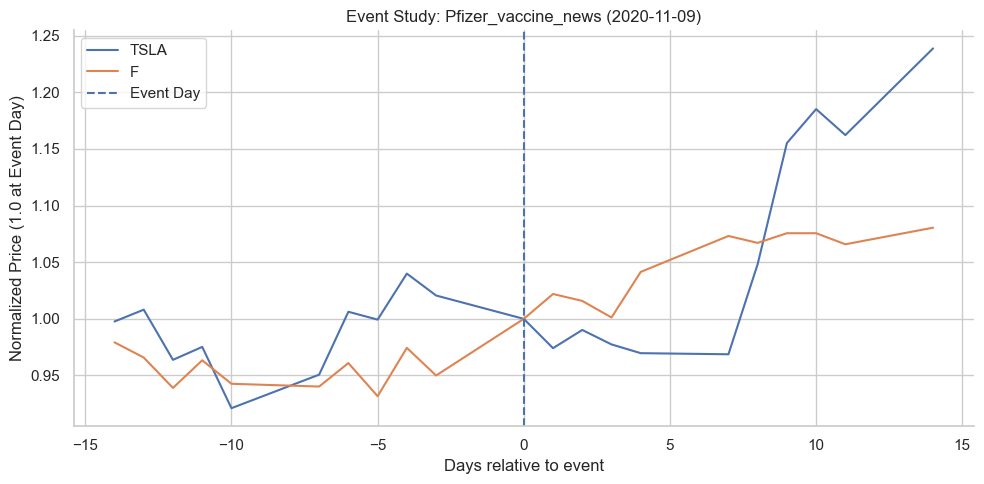

Cumulative return from event day to end of window for Pfizer_vaccine_news:


,Cumulative_Return
Ticker,
TSLA,0.2388
F,0.0805


In [13]:
#  Event-study plots for each COVID-related event

def plot_event_window(prices_df, event_name, event_date, window_days):
    """
    Plot normalized TSLA and F prices around a given event date.
    """
    # We'll use closing prices for TSLA and F only
    sub_df, effective_event_date = get_event_window(
        prices_df[["TSLA", "F"]],
        event_date=event_date,
        window=window_days
    )

    # Normalize prices to 1.0 on event date
    event_prices = sub_df.copy()
    event_day_prices = event_prices.loc[effective_event_date]
    event_prices_norm = event_prices / event_day_prices

    # Use an integer-based day offset around the event
    event_prices_norm["day_offset"] = (event_prices_norm.index - effective_event_date).days

    # Plot
    plt.figure()
    for col in ["TSLA", "F"]:
        plt.plot(
            event_prices_norm["day_offset"],
            event_prices_norm[col],
            label=col
        )

    plt.axvline(x=0, linestyle="--", label="Event Day")
    plt.title(f"Event Study: {event_name} ({effective_event_date.date()})")
    plt.xlabel("Days relative to event")
    plt.ylabel("Normalized Price (1.0 at Event Day)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Compute and print cumulative returns in the window
    cum_ret = (event_prices / event_day_prices - 1).iloc[-1][["TSLA", "F"]]
    print(f"Cumulative return from event day to end of window for {event_name}:")
    display(cum_ret.to_frame("Cumulative_Return"))
    

for ev_name, ev_date in event_dates.items():
    print("=" * 80)
    print(f"Event: {ev_name} ({ev_date})")
    plot_event_window(prices, ev_name, ev_date, event_window_days)


### **Event-Window Volatility Comparison**

In [14]:
#  Event-window volatility before vs after each event

def summarize_event_volatility(ret_df, event_name, event_date, window_days):
    """
    For each event:
    - compute volatility in the pre-window ([-window, -1])
    - compute volatility in the post-window ([0, +window])
    for TSLA and F.
    """
    sub_df, effective_event_date = get_event_window(
        ret_df[["TSLA_ret", "F_ret"]],
        event_date=event_date,
        window=window_days
    )

    # Add day offset
    sub_df["day_offset"] = (sub_df.index - effective_event_date).days

    pre_mask = sub_df["day_offset"].between(-window_days, -1)
    post_mask = sub_df["day_offset"].between(0, window_days)

    pre_vol = sub_df.loc[pre_mask, ["TSLA_ret", "F_ret"]].std()
    post_vol = sub_df.loc[post_mask, ["TSLA_ret", "F_ret"]].std()

    result = pd.DataFrame(
        {
            "Pre-Event Volatility": pre_vol,
            "Post-Event Volatility": post_vol
        }
    )
    result.index = ["TSLA", "F"]

    print(f"Volatility around {event_name} ({effective_event_date.date()}):")
    display(result)

    return result


event_vol_results = {}

for ev_name, ev_date in event_dates.items():
    print("=" * 80)
    print(f"Event: {ev_name} ({ev_date})")
    event_vol_results[ev_name] = summarize_event_volatility(
        returns,
        ev_name,
        ev_date,
        window_days=event_window_days
    )


Event: WHO_pandemic_announcement (2020-03-11)
Volatility around WHO_pandemic_announcement (2020-03-11):


,Pre-Event Volatility,Post-Event Volatility
TSLA,0.0785,0.1158
F,0.0529,0.0574


Event: CARES_Act_signed (2020-03-27)
Volatility around CARES_Act_signed (2020-03-27):


,Pre-Event Volatility,Post-Event Volatility
TSLA,0.1112,0.0601
F,0.1066,0.0471


Event: Pfizer_vaccine_news (2020-11-09)
Volatility around Pfizer_vaccine_news (2020-11-09):


,Pre-Event Volatility,Post-Event Volatility
TSLA,0.0428,0.0456
F,0.0303,0.0233
